Independent Data Analysis - Twitter

In [1]:
import os
import json
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime
import random
from googletrans import Translator, LANGUAGES
import requests

from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from twython import Twython
from twitter_streamer import MyStreamer

from translator_tool import GoogleTransTool
from utils import *
from private_keys import API_KEY, API_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET

In [2]:
tokens = [API_KEY, API_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET]

In [3]:
twit = Twython(*tokens)

MyStreamer instance - extends TwythonStreamer

In [4]:
streamer = MyStreamer(*tokens)

GoogleTransTool instance - utilizes googletrans module to query Google's tranlation service

In [5]:
trans = GoogleTransTool()

Tag dictionary for storing tag meanings

In [6]:
global_tag_dict = dict()

#### Find the most frequently used hashtags in twitter stream - include translations

In [1]:
def collect_samples(twitter_streamer, n_samples=1, tweets_per_sample=100):
    """Use MyStreamer class to sample realtime tweets
    
    Arguments:
    n_samples -- number of samples to take from stream
    tweets_per_sample -- number of tweets collected per sample
    
    sample loop breaks when streamer status is ERROR
    """
    samples = list()
    for i in range(n_samples):
        tweet_samples = twitter_streamer.sample(max_count=tweets_per_sample)
        if twitter_streamer.status == twitter_streamer.ERROR:
            break
        samples += tweet_samples
        
    return list(filter(lambda t: 'delete' not in t, samples))

In [8]:
samples = list()

In [9]:
samples += collect_samples(streamer)

Done - 100 tweet samples collected
Reseting...


In [10]:
translations = [trans.translate_text(tag) for tag in list_hashtags(gen_sub_tweets(samples))]

In [11]:
parse_trans = [trans.parse_translation(each) for each in translations]

Use tagdef.com to query meaning of hashtags

In [12]:
def parse_tagdef(content):
    content = str(content)
    if "<text>" in content:
        return str(content).split("<text>")[1].split("</text>")[0]
    return ""

In [13]:
def fetch_tagdef(tagname):
    output = None
    if tagname in global_tag_dict:
        output = global_tag_dict[tagname]
    else:
        output = requests.get("https://api.tagdef.com/{}".format(tagname)).content
        global_tag_dict[tagname] = output
    return output

In [14]:
def fetch_parse_tagdef(tagname):
    return parse_tagdef(fetch_tagdef(tagname))

In [15]:
fetch_parse_tagdef("thezonecast")

'Hashtag used for Adventure Zone.  The Adventure Zone is a bi-weekly comedy and adventure podcast based loosely upon the popular Dungeons &amp; Dragons game series.  Regular episodes of the podcast feature the family solving puzzles, fighting enemies, and leveling up their characters in a series of cinematic and humorous encounters.'

In [16]:
sample_trans = list(zip(parse_trans, [fetch_parse_tagdef(trans[1]) for trans in parse_trans]))

In [17]:
sample_trans[:5]

[(('english', 'OpenFollow'),
  "It\\'s saying that you\\'re currently looking for people to follow, some users add a fandom at tweet meaning they only follow specific people"),
 (('english', 'JFB'), ''),
 (('korean', 'Bulletproof Boy Scouts'), ''),
 (('english', 'iHeartRadioMMVAs'), ''),
 (('english', 'MMVAs'), '')]

#### Find the most frequently used hashtag by location

In [18]:
def get_woeid(place):
    """Fetch 'Where on Earth ID' from yahoo API"""
    
    #formatter to encode commas and space for URLs
    formatter = lambda s: "%22" + s.replace(",", "%2C").replace(" ", "%20") + "%22"
    
    url = "https://query.yahooapis.com/v1/public/yql?q=select%20woeid%20from%20geo.places(1)%20where%20text%3D{}&format=json&env=store%3A%2F%2Fdatatables.org%2Falltableswithkeys"\
    .format(formatter(place))
    
    content = requests.get(url).json()
    results = content["query"]["results"]
    
    if results is None:
        raise Exception("Bad place name")
    
    return results["place"]["woeid"]

In [19]:
get_woeid("zurich, ch")

'784794'

In [20]:
get_woeid("atlanta, georgia")

'2357024'

In [21]:
def get_trending_place_hashtags(twit, place_name):
    """Fetch hashtags by place - Twython get_place_trends endpoint
    
    Arguments:
    twit -- twython.Twython instance
    place_name -- string of town, city, state, country name (ex: 'zurich, ch', 'atlanta, georgia')
    
    return: list of json objects with information on trending hashtags
    """
    tags = list()
    try:
        return twit.get_place_trends(id=get_woeid(place_name))[0]['trends']
    except Exception as e:
        print(e)

In [22]:
def parse_trending_name_volume(tag_list):
    """
    Create tuple list of 'name' and 'volume' in hashtag json objects as returned from Twython().get_place_trends()
    """
    return [(tag['name'].strip("#"), tag['tweet_volume'] or 0) for tag in tag_list]

In [23]:
zurich_trending = get_trending_place_hashtags(twit, "zurich, ch")

In [24]:
atlanta_trending = get_trending_place_hashtags(twit, "atlanta, georgia")

In [25]:
def plot_hashtags_trending_counts(tag_list, opt_label=None, annotate=False, color='b'):
    """
    Argument - list of hashtags as returned by Twython().get_place_trends()
    
    -Create dataframe of tag_list with "name" and "volume" columns
    -Sort dataframe in descending order
    -Filter any 0 values in volume
        - 0 value returned for some trending hashtags - unknown reason
        
    create barplot of volume by hashtag
    """
    
    # new dataframe with optional 'annotate' column
    df = pd.DataFrame(parse_trending_name_volume(tag_list), columns=["name", "volume"])
    df = df.sort_values("volume", ascending=False).loc[ df.volume/max(df.volume) > 0.01]
    if annotate:
        df = df.assign(annotate=[fetch_parse_tagdef(tag) for tag in df.name])
        
    # initialize ax and barplot
    _, ax = plt.subplots(figsize=(6, 8))
    sns.set_color_codes("pastel")
    g = sns.barplot(x="volume", y="name", data=df, color=color)

    # create ax label and update if opt_label is provided
    opt_label = "" if opt_label is None else " - " + opt_label
    ax.set(xlim=(0, max(df.volume)), ylabel="",
           xlabel="Volume of tweets with hashtag{}".format(opt_label))
    
    plt.tight_layout()
    sns.despine(left=True, bottom=True)
    
    # update xticks for prettier output
    n = 5
    new_xticks = [big_round(i*max(df.volume)/n, 3) for i in range(n)]
    if len(list(ax.get_xticklabels()))-2 > n:
        ax.set_xticks(new_xticks)
        
    # optional annotation of plot with meaning of hashtag
    lim=75
    if annotate:
        for j, text in enumerate(df.annotate):
            if len(text) > 0:
                text = text if len(text) < lim else text[:lim] + "..."
                ax.annotate(text, xy=(0, j))
    

In [26]:
plot_hashtags_trending_counts(atlanta_trending, "Atlanta, Georgia", True)

In [27]:
plot_hashtags_trending_counts(zurich_trending, "Zurich, Switzerland", True)

---

#### Choose 3-4 famous American celebrities, analyse their twitter usage (e.g. number of tweets, relative time between tweets, etc. and compare the results to Donald Trump’s Twitter account.)

In [28]:
def gen_df_user_timeline(twit, screen_name, since_id=None):
    return gen_df_tweets(twit.get_user_timeline(screen_name=screen_name, count=200, since_id=since_id))

In [29]:
def gen_df_users(twit, user_list, since_id=None):
    output = gen_df_user_timeline(twit, user_list[0])
    for user in user_list[1:]:
        output = pd.concat([output, gen_df_user_timeline(twit, user)], axis=0)
        
    if 0 in output.columns:
        output = output.drop(0, axis=1)
        
    if pd.isna(output.iloc[0].any()):
        output = output.drop(0, axis=0)
        
    output = output.assign(str_tags = list(map(hashtags_to_string, output.hashtags)),
                           date = list(map(clean_date, output.date)))

    return output

In [30]:
def hashtags_to_string(hashtags):
    text = [tag['text'] if 'text' in tag else "" for tag in hashtags]
    return ", ".join(text)

In [31]:
def clean_date(date_str):
    """Assume format: Fri Apr 06 19:22:00 +0000 2018"""
    return " ".join(date_str.split(" ")[:3])

In [32]:
# earliest = trump_df.sort_values("date").iloc[0,:].id

In [33]:
user_list = ["realdonaldtrump","kanyewest", "theellenshow", "seanhannity", "trevornoah", "foxnews", "cnn"]

In [34]:
all_users = gen_df_users(twit, user_list)

In [35]:
all_users.columns

Index(['date', 'hashtags', 'id', 'screen_name', 'text', 'timestamp_ms',
       'user_id', 'user_name', 'num_hashtags', 'str_tags'],
      dtype='object')

---

In [36]:
all_users.groupby("user_id").count()

date  hashtags   id  screen_name  text  timestamp_ms  user_name  \
user_id                                                                      
1367531     200       200  200          200   200           200        200   
15846407    200       200  200          200   200           200        200   
169686021   200       200  200          200   200           200        200   
25073877    200       200  200          200   200           200        200   
41634520    200       200  200          200   200           200        200   
46335511    196       196  196          196   196           196        196   
759251      200       200  200          200   200           200        200   

           num_hashtags  str_tags  
user_id                            
1367531             200       200  
15846407            200       200  
169686021           200       200  
25073877            200       200  
41634520            200       200  
46335511            196       196  
759251              200       200

In [37]:
all_users[all_users.user_id == "46335511"].iloc[0,]["screen_name"]

'Trevornoah'

In [38]:
users_group_date = all_users.groupby(["date"]).count().reset_index()

In [39]:
sorted_group_date = users_group_date.sort_values("timestamp_ms")

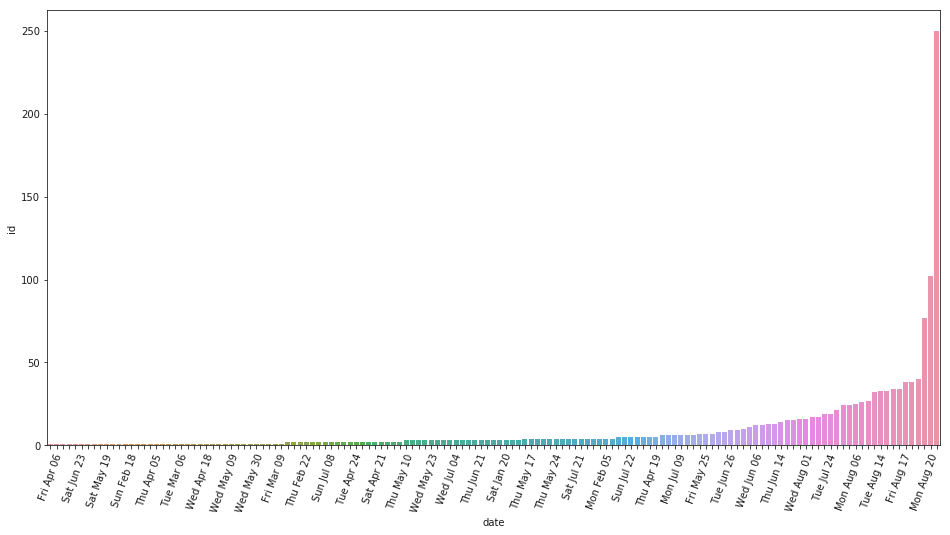

In [40]:
_, ax = plt.subplots(figsize=(16, 8))
g = sns.barplot(x="date", y="id", data=sorted_group_date)

## stagger xticklabels for prettier output
g.set_xticklabels([tick if i%4 == 0 else "" for i, tick in enumerate(g.get_xticklabels())], rotation=70)
plt.show()

---

Persist Tweets - to compare with future tweets

In [41]:
# all_users = all_users.assign(str_tags = list(map(hashtags_to_string, all_users.hashtags)))

In [43]:
#Save tweets to sqlite3 database
with sqlite3.connect("data/user_tweets.sqlite") as conn:
    all_users.drop(["hashtags", "date"], axis=1).to_sql("Tweets", conn)

---

In [ ]:
# TODO: shiny app with twitter streamer

In [ ]:
# TODO: deploy streamer for saving tweets in realtime

In [ ]:
# TODO: functions to compress/decompress tweet dataframes - str_tag to/from hashtags, timestamp_ms to/from date